In [2]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool
import cv2

In [2]:
dfAll = pd.read_pickle("PklData/AllData.pkl")
dfAll.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
0,3,1545216073822,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."
1,3,1545216073826,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."
2,3,1545216073867,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."
3,3,1545216073911,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."
4,3,1545216073945,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."


In [3]:
df_actual = dfAll[(dfAll.Actual_Data == True) & (dfAll.Is_Pause == False)]
df_actual.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
9921,3,1545216477388,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
9922,3,1545216477425,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
9923,3,1545216477464,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
9924,3,1545216477504,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
9925,3,1545216477545,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, ..."


In [4]:
print("all: %s, actual data: %s" % (len(dfAll), len(df_actual)))

all: 548776, actual data: 460294


In [5]:
"""%%time
# this will be the faster repetition check
def is_max(row):
    return row.RepetitionID == df_filtered[(df_filtered.userID == row.userID) & (df_filtered.TaskID == row.TaskID) & (df_filtered.VersionID == row.VersionID)].RepetitionID.max()

pool = Pool(8)
df_filtered = df_actual.copy(deep=True)

max_vals = pool.map(is_max, [row for index, row in df_filtered.iterrows()])
df_filtered["IsMax"] = max_vals
print(df_filtered.head())
pool.close()"""

'%%time\n# this will be the faster repetition check\ndef is_max(row):\n    return row.RepetitionID == df_filtered[(df_filtered.userID == row.userID) & (df_filtered.TaskID == row.TaskID) & (df_filtered.VersionID == row.VersionID)].RepetitionID.max()\n\npool = Pool(8)\ndf_filtered = df_actual.copy(deep=True)\n\nmax_vals = pool.map(is_max, [row for index, row in df_filtered.iterrows()])\ndf_filtered["IsMax"] = max_vals\nprint(df_filtered.head())\npool.close()'

In [ ]:
%%time
df_filtered = df_actual.copy(deep=True)
for User in df_filtered.userID.unique():
    print(User)
    for Task in df_filtered.TaskID.unique():
        for Version in df_filtered.VersionID.unique():
            max_rep = df_filtered[(df_filtered.userID == User) & (df_filtered.TaskID == Task) & (df_filtered.VersionID == Version)].RepetitionID.max()
            df_filtered = df_filtered.drop(df_filtered[(df_filtered.userID == User) & (df_filtered.TaskID == Task) & (df_filtered.VersionID == Version) & (df_filtered.RepetitionID != max_rep)].index)

3


In [1]:
#df_filtered.to_pickle("PklData/dfFiltered.pkl")

NameError: name 'df_filtered' is not defined

In [7]:
print("actual: %s, filtered data: %s" % (len(df_actual), len(df_filtered)))

actual: 460294, filtered data: 309844


In [ ]:
df_filtered = pd.read_pickle("PklData/dfFiltered.pkl")

In [8]:
#Old Blob Detection
""" 
crop_frame = 5

def detect_blobs(image):
    image = image.reshape(27, 15)
    temp, thresh = cv2.threshold(cv2.bitwise_not(image), 200, 255, cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 5 and cv2.contourArea(a) < 255]
    if len(contours) > 0:
        max_contour = max(contours, key=lambda a: cv2.contourArea(a))
        xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
        xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
        croped_im = np.zeros((27,15))
        blob = image[max(ymin - 1, 0):min(ymax + 1, image.shape[0]),max(xmin - 1, 0):min(xmax + 1, image.shape[1])]
        croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
        return (1, [croped_im])
    else:
        return (0, np.zeros((27,15)))
"""

In [4]:
df_filtered.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
9927,3,1545216477627,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, ..."
9928,3,1545216477665,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, ..."
9929,3,1545216477716,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, ..."
9930,3,1545216477751,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, ..."
9931,3,1545216477785,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, ..."


In [7]:
df_filtered.Image = df_filtered.Image.apply(lambda x: x.reshape(27, 15))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.clip(min=0, max=255))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.astype(np.uint8))
df_filtered["ImageSum"] = df_filtered.Image.apply(lambda x: np.sum(x))

In [18]:
#Svens new Blob detection
def detect_blobs(image):
    #image = image.reshape(27, 15)
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = image
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 200, 255, cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 5 and cv2.contourArea(a) < 255]
    lst  = []
    count = 0
    if len(contours) > 0:
        max_contour = max(contours, key=lambda a: cv2.contourArea(a))
        xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
        xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
        #croped_im = np.zeros((27,15))
        blob = large[max(ymin - 1, 0):min(ymax + 1, image.shape[0]),max(xmin - 1, 0):min(xmax + 1, image.shape[1])]
        #croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
        #return (1, [croped_im])
        lst.append(blob)
        count = count + 1
    else:
        return (0, np.zeros((29,17)), 0, 0)
    
    return (count, [lst], xmax-xmin, ymax-ymin)

In [19]:
%%time
pool = Pool(8)
temp_blobs = pool.map(detect_blobs, df_filtered.Image)
pool.close()

CPU times: user 6.39 s, sys: 2.84 s, total: 9.23 s
Wall time: 10.9 s


In [20]:
df_filtered["BlobCount"] = [a[0] for a in temp_blobs]
df_filtered["BlobImages"] = [a[1] for a in temp_blobs]
df_filtered["BlobW"] = [a[2] for a in temp_blobs]
df_filtered["BlobH"] = [a[3] for a in temp_blobs]
df_filtered["BlobArea"] = df_filtered["BlobW"]* df_filtered["BlobH"]

In [26]:
print(len(df_filtered[df_filtered.BlobCount > 0]))
df = df_filtered[df_filtered.BlobCount > 0].copy(deep=True)
print(len(df_filtered))

83906
309844


In [27]:
df.BlobArea.describe().round(1)

count    83906.0
mean        13.4
std          4.6
min          8.0
25%          9.0
50%         12.0
75%         16.0
max         72.0
Name: BlobArea, dtype: float64

In [28]:
df.BlobImages = df.BlobImages.apply(lambda x: x[0][0])

In [29]:
df["BlobSum"] = df.BlobImages.apply(lambda x: np.sum(x))

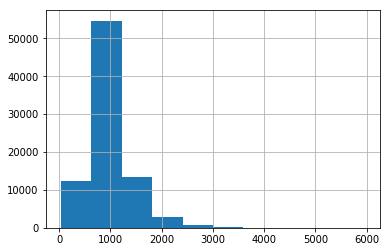

In [30]:
df.BlobSum.hist()

In [50]:
#Small / Blobs where the pixels are only a "little" hit
dfX = df[df.BlobSum <= 255]
len(dfX)

502

In [59]:
#Augmenting by flipping in both axis (datax4)
df["Version"] = "Normal"
dfFlipped = df.copy(deep=True)
dfFlipped.BlobImages = dfFlipped.BlobImages.apply(lambda x: np.flipud(x))
dfFlipped["Version"] = "FlippedUD"
df = df.append(dfFlipped)
dfFlipped = df.copy(deep=True)
dfFlipped.BlobImages = dfFlipped.BlobImages.apply(lambda x: np.fliplr(x))
dfFlipped["Version"] = "FlippedLR"
df = df.append(dfFlipped)

In [60]:
def pasteToEmpty (blob):
    croped_im = np.zeros((27,15))
    croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
    return croped_im

In [63]:
df["Image"] = df.BlobImages.apply(lambda x: pasteToEmpty(x))

In [77]:
#Label if knuckle or finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df['InputMethod'] = df.apply(f, axis=1)

In [78]:
df[["userID", "TaskID", "Version", "Image"]].to_pickle("PklData/df_blobs.pkl")

In [ ]:
#glaube das war alt
df_blobs = df_croped[df_croped.BlobCount == 1]
print("detected blobs: %s" % len(df_blobs))
df_blobs.head()

In [11]:
df_blobs.to_pickle("PklData/df_blobs.pkl")

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 431, in _handle_workers
    maxtasksperchild, wrap_exception)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 268, in _maintain_pool
    wrap_exception)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 255, in _repopulate_pool_static
    w.start()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 66, in _launch
    self.pid

# display blobs

<Figure size 432x288 with 0 Axes>

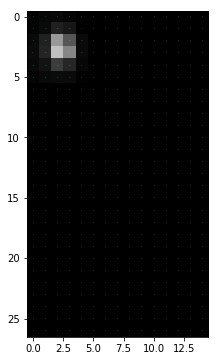

In [12]:
plt.clf()
plt.figure(figsize=(6, 6))
ax = plt.gca()
data_point = 1000
data = df_blobs.Blobs.iloc[data_point][0]
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
# Loop over data dimensions and create text annotations.
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        text = ax.text(j, i, int(data[i, j]),
                       ha="center", va="center", color="cyan", fontsize=1)
# plt.savefig("input.png", bbox_inches='tight')
plt.show()

In [13]:
df_blobs.userID.unique()

array([ 3,  7,  5,  9,  6, 10,  2,  4,  1,  8])